# Vindr-Mammo dataset analysis

As described by the authors, the project directory contains the following files and subfolder:

- **Annotations files**:  
  - `breast-level_annotations.csv`  
  - `finding_annotations.csv`  
- **Metadata file**:  
  - `metadata.csv`  
- **Subfolder**:  
  - `images` (contains DICOM files)

---

### `images` Subfolder

- Contains **5,000 subdirectories**, each corresponding to an exam in the dataset.
- The **folder name** is the hashed study identifier of the exam.
- Each folder contains **four DICOM files** for two standard views of each breast.
- **Path format**:  
  `images/<study_id>/<image_id>.dicom`

---

### Annotations Files

#### `breast-level_annotations.csv`

- Each row corresponds to an image and provides the BI-RADS assessment along with metadata.
- **Attributes**:
  - `study_id`: Encoded study identifier.
  - `series_id`: Encoded series identifier.
  - `laterality`: Laterality of the breast (L or R).
  - `view_position`: Orientation of the image (CC or MLO).
  - `height`: Height of the image.
  - `width`: Width of the image.
  - `breast_birads`: BI-RADS assessment of the breast.
  - `breast_density`: Density category of the breast.
  - `split`: Indicates the split to which the image belongs (`training` or `test`).

---

#### `finding_annotations.csv`

- Each row represents an annotation of a breast abnormality in an image.
- **Image metadata**:  
  - `image_id`, `study_id`, `series_id`, `laterality`, `view_position`, `height`, `width`, `breast_birads`, `breast_density`, `split`
- **Annotation metadata**:
  - `finding_categories`: List of finding categories (e.g., `["Mass", "Skin Retraction"]`).
  - `finding_birads`: BI-RADS assessment of the marked finding.
  - `xmin`, `ymin`, `xmax`, `ymax`: Coordinates of the bounding box.

---

### `metadata.csv`

- Contains DICOM tag information relevant for research:
  - Patient's age.
  - Imaging device model.
  - Manufacturer.

In [31]:
from glob import glob 

data_dir = "/mnt/d/datasets/vindr-mammo/data"
f_list = glob(data_dir + '/*')
print('The dataset directory contains :')
for i in f_list:
    print(f'    - {i}')

The dataset directory contains :
    - /mnt/d/datasets/vindr-mammo/data/LICENSE.txt
    - /mnt/d/datasets/vindr-mammo/data/SHA256SUMS.txt
    - /mnt/d/datasets/vindr-mammo/data/breast-level_annotations.csv
    - /mnt/d/datasets/vindr-mammo/data/finding_annotations.csv
    - /mnt/d/datasets/vindr-mammo/data/metadata.csv
    - /mnt/d/datasets/vindr-mammo/data/images


According to the dataset description : 

- finding_annotations.csv, could be used to prepare the dataset for both lesion-based classification and segmentation tasks.
- breast-level_annotations.csv, could be used to prepare the dataset for a bi-rads based classification.

### Extraction protocol - Lesion-based classification

1. Get the names of unique findings
2. Rename the finding_categories cells of the finding_annotations.csv to facilitate later access to this column. 
3. Remove any row where finding_categories is NaN.
4. Create a per-lesion filter.
5. Iterate through the rows and load the dicom file using study_id and image_id. (optional) Create and display a bounding box on the annotated lesion. 
6. Save extracted images in a .h5 file with its associated label.

##### 1. Names of unique finding categories

In [32]:
import ast
import os
import pandas as pd
import numpy as np

df_meta = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))
df_find = pd.read_csv(os.path.join(data_dir, 'finding_annotations.csv'))
df_anno = pd.read_csv(os.path.join(data_dir, 'breast-level_annotations.csv'))

original_df_find_len = len(df_find)

df_find['finding_categories'] = df_find['finding_categories'].apply(ast.literal_eval)
unique_categories = pd.unique(np.array([item for sublist in df_find['finding_categories'] for item in sublist]))
print('Unique categories found :')
for i in unique_categories:
    print(f'    - {i}')

Unique categories found :
    - Mass
    - Global Asymmetry
    - Architectural Distortion
    - Nipple Retraction
    - Suspicious Calcification
    - Focal Asymmetry
    - Asymmetry
    - Skin Thickening
    - Suspicious Lymph Node
    - Skin Retraction
    - No Finding


##### 2. Rename categories

In [33]:
def format_category_list(category_list):
    return [category.lower().replace(' ', '_') for category in category_list]

df_find['finding_categories'] = df_find['finding_categories'].apply(format_category_list)
print(df_find['finding_categories'].iloc[5])

['architectural_distortion']


##### 3. Check if there are rows without finding categories

In [34]:
has_nan = df_find['finding_categories'].isna().unique()
has_nan

array([False])

All studies have defined finding categories, continuing ...

##### 4. Create a per-lesion based filter

The filter takes a list of classes that we would like to keep inside the dataset.
The result is a finding_annotations dataframe which rows only contain one or of these filtered classes.

In [37]:
class_list = ['mass', 'suspicious_calcification', 'suspicious_lymph_node']

def contains_all_classes(category_list, class_list):
    return any(cls in category_list for cls in class_list)

df_find = df_find[df_find['finding_categories'].apply(lambda x: contains_all_classes(x, class_list))]
print('{} lines were removed from the dataset. The dataset now contains {} images'.format(original_df_find_len - len(df_find), len(df_find)))

def replace_categories(df, column, target_categories):
    def replace_if_present(categories):
        for target in target_categories:
            if target in categories:
                return target
        return categories

    df[column] = df[column].apply(lambda x: replace_if_present(x) if isinstance(x, list) else x)
    return df

df_find = replace_categories(df_find, 'finding_categories', class_list)

18750 lines were removed from the dataset. The dataset now contains 1736 images


##### 5. Load dicom file

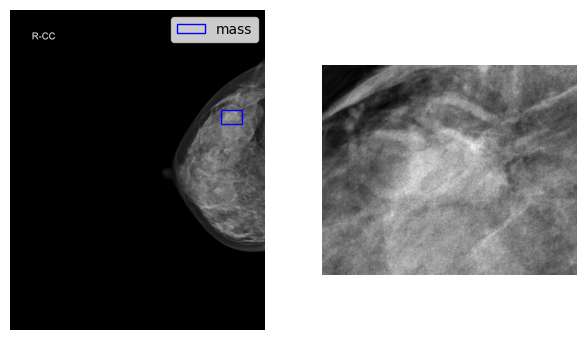

In [38]:
import matplotlib.pyplot as plt
from matplotlib import patches

from pydicom import dcmread
from pydicom.pixel_data_handlers import apply_voi_lut

def load_dicom_image(path):
    ds = dcmread(path)
    img2d = ds.pixel_array
    img2d = apply_voi_lut(img2d, ds)
    
    if ds.PhotometricInterpretation == "MONOCHROME1":
        img2d = np.amax(img2d) - img2d
    
    img2d = img2d.astype(np.float32)
    normalized_data = (img2d - np.min(img2d)) / (np.max(img2d) - np.min(img2d))
    return normalized_data

def extract_patch(image, xmin, xmax, ymin, ymax, padding=100):
    ymin = max(0, ymin - padding)
    xmin = max(0, xmin - padding)
    ymax = min(image.shape[0], ymax + padding)
    xmax = min(image.shape[1], xmax + padding)
    return image[ymin:ymax, xmin:xmax]


sample = df_find.iloc[29]
sample_path = os.path.join(data_dir, 'images', sample['study_id'], sample['image_id'] + '.dicom')
sample_img = load_dicom_image(sample_path)

xmin, xmax = int(sample['xmin']), int(sample['xmax'])
ymin, ymax = int(sample['ymin']), int(sample['ymax'])
bbox_width = xmax - xmin
bbox_height = ymax - ymin

patch = extract_patch(sample_img, xmin, xmax, ymin, ymax)

fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].imshow(sample_img, cmap='gray')
rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=1, edgecolor='b', label=sample['finding_categories'], facecolor='none')
ax[0].add_patch(rect)
ax[0].legend()
ax[0].axis('off')

ax[1].imshow(patch, cmap='gray')
ax[1].axis('off')

plt.show()

In [39]:
import cv2

resized_image = cv2.resize(
    sample_img,
    (512, 512),
    interpolation=cv2.INTER_LINEAR,
)


##### 7. Iterate through the entire dataset and save images in an H5 file 

In [19]:
def process_row(data_dir, row):
    """
    Function to load and process a DICOM image.
    Converts the DICOM image into a numpy array of type float32.
    """
    sample_path = os.path.join(data_dir, 'images', row['study_id'], row['image_id'] + '.dicom')
    sample_img = load_dicom_image(sample_path)
    sample_img = cv2.resize(
        sample_img,
        (512, 512),
        interpolation=cv2.INTER_LINEAR,
    )
    return sample_img